In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from sklearn.model_selection import train_test_split



# Import Keras
import keras as K
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.applications import Xception, ResNet50V2
from keras.applications.xception import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.losses import CategoricalCrossentropy


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train = unpickle("cifar-100-python\\train")
test = unpickle("cifar-100-python\\test")
meta = unpickle("cifar-100-python\\meta")

In [6]:
print(train[b'data'].shape)

(50000, 3072)


In [7]:
def display_rd_img(dataset):
    load = dataset[b'data']
    num = rd.randint(0, len(load))
    title = str(dataset[b'filenames'][num])
    title = title.split("\'")[1].split("_s_")[0]
    img = load[num]
    img = img.reshape((3,32,32)).transpose(1,2,0)
    print(type(img))
    plt.imshow(img)
    plt.title(title)


<class 'numpy.ndarray'>


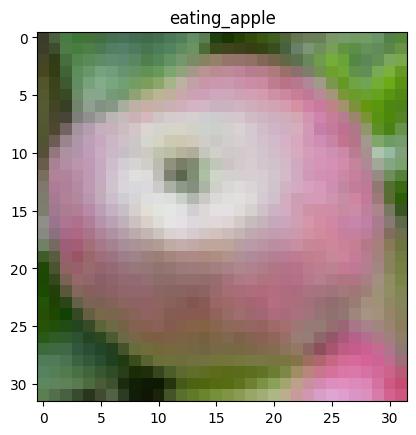

In [8]:
display_rd_img(train)

In [9]:
def pre_process(dataset, target_size=(96, 96)):
    data = dataset[b'data']
    result = []
    
    for i in range(len(data)):
        temp = data[i].reshape((3, 32, 32)).transpose(1, 2, 0)  # Convertir en (H, W, C)
        temp = tf.image.resize(temp, target_size, method=tf.image.ResizeMethod.BICUBIC) 
        result.append(temp.numpy())  # Convertir le tenseur en numpy array

    return result


p_train = pre_process(train)    

In [10]:
trained_label = train[b'fine_labels']

In [11]:
print(len(p_train))

50000


In [12]:
class CIFAR100Generator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True, num_classes=100, augment=False):
        self.images = np.array(images, dtype=np.float32) 
        self.labels = np.array(labels, dtype=np.int32)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.augment = augment  # Activation ou non de l'augmentation
        self.indices = np.arange(len(self.images))
        self.images = preprocess_input(self.images)  
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.images) // self.batch_size  # Nombre total de batchs par epoch

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]

        # Convertir les labels en one-hot encoding
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        # Appliquer l'augmentation uniquement pour l'entraînement
        if self.augment:
            batch_images = self.augment_images(batch_images)

        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def augment_images(self, batch_images):
        batch_images_aug = []
        for img in batch_images:
            if np.random.rand() > 0.5:  # 50% des images restent inchangées
                batch_images_aug.append(img)
            else:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, max_delta=0.2)
                img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
                img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
                img = tf.image.rot90(img, k=np.random.randint(4))
                img = tf.image.random_crop(img, size=[96, 96, 3])
                batch_images_aug.append(img)
        
        batch_images_aug = tf.convert_to_tensor(batch_images_aug, dtype=tf.float32)  # ✅ Convertir en tenseur TensorFlow
        return batch_images_aug.numpy()  # ✅ Convertir proprement en NumPy




def create_generators(images, labels, batch_size=32, val_split=0.2):
    """
    Sépare les données en train/val et retourne deux générateurs.
    """
    # Séparation des données en train et validation
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=val_split, random_state=42)

    # Création des générateurs
    train_generator = CIFAR100Generator(X_train, y_train, batch_size=batch_size, shuffle=True, augment=True)  # Augmentation activée
    val_generator = CIFAR100Generator(X_val, y_val, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return train_generator, val_generator



def create_test_generator(images, labels, batch_size=32):
    # Création des générateurs
    test_generator = CIFAR100Generator(images, labels, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return test_generator


In [13]:
train_generator, val_generator = create_generators(p_train, trained_label, batch_size=64)

In [14]:
x_batch, y_batch = train_generator[0]
print("Shape des images:", x_batch.shape)  # Doit être (batch_size, 32, 32, 3)
print("Shape des labels:", y_batch.shape)  # Doit être (batch_size, 100)


Shape des images: (64, 96, 96, 3)
Shape des labels: (64, 100)


In [ ]:
def neural_net(num_neurones,num_hidden_layers,dropout_rate, early_stop_patience, lr_scheduler_patience, train_generator,learning_rate= 0.0001):
    base_model = Xception(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    # Ajouter des couches personnalisées
    for _ in range (0, num_hidden_layers): 
        x = Dense(num_neurones, activation='relu')(x)  # Ajouter une couche Dense pour l'apprentissage des caractéristiques
        #x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)  # Ajouter une couche de dropout pour réduire le surapprentissage
    predictions = Dense(100, activation='softmax')(x)  # Couche de sortie pour 100 classes

    # Configurer les callbacks
    checkpoint = ModelCheckpoint("test.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stop_patience, verbose=1, mode='auto')
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=lr_scheduler_patience)
    callbacks = [checkpoint, early, lr_scheduler]

    # Créer l'instance de l'optimiseur avec le learning rate spécifié
    optimizer = Adam(learning_rate=learning_rate)
    #optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)


    # Compiler le modèle avec l'optimiseur configuré
    model = Model(inputs= base_model.input , outputs=predictions)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
    return model, callbacks

# Entraîner le modèle
def training(model, cb, n_epoch):
    history = model.fit(
        train_generator,
        epochs=n_epoch,
        validation_data=val_generator,
        callbacks=cb)
    
    model.save('test_final.h5')
    return history

def plot_history(history):
    # Tracer la précision et la perte
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Epoch 1/200
625/625 [==============================] - ETA: 0s - loss: 4.3086 - accuracy: 0.0732
Epoch 1: val_loss improved from inf to 3.61284, saving model to test.h5
625/625 [==============================] - 198s 270ms/step - loss: 4.3086 - accuracy: 0.0732 - val_loss: 3.6128 - val_accuracy: 0.2340 - lr: 1.0000e-04
Epoch 2/200
625/625 [==============================] - ETA: 0s - loss: 3.4424 - accuracy: 0.2634
Epoch 2: val_loss improved from 3.61284 to 2.45314, saving model to test.h5
625/625 [==============================] - 166s 265ms/step - loss: 3.4424 - accuracy: 0.2634 - val_loss: 2.4531 - val_accuracy: 0.4857 - lr: 1.0000e-04
Epoch 3/200
625/625 [==============================] - ETA: 0s - loss: 2.6080 - accuracy: 0.4583
Epoch 3: val_loss improved from 2.45314 to 1.96399, saving model to test.h5
625/625 [==============================] - 166s 266ms/step - loss: 2.6080 - accuracy: 0.4583 - val_loss: 1.9640 - val_accuracy: 0.6355 - lr: 1.0000e-04
Epoch 4/200
625/625 [========

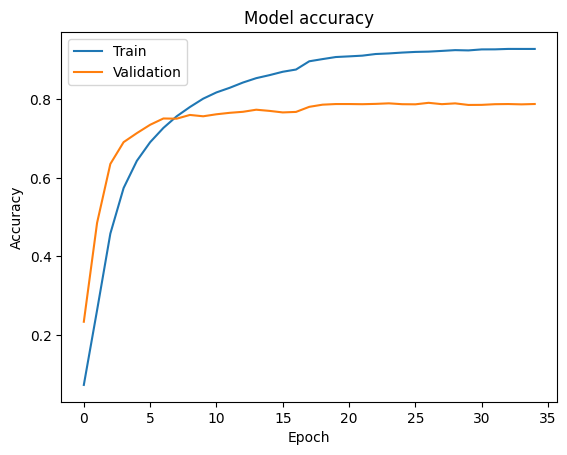

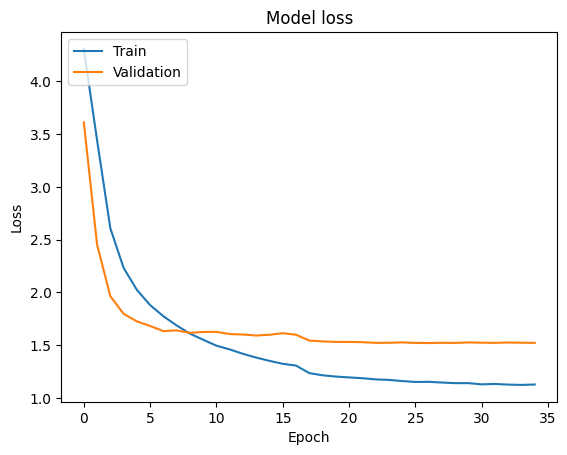

In [17]:
model, callback = neural_net(num_neurones=512, num_hidden_layers=3, 
                            dropout_rate=0.4, early_stop_patience=8, 
                            lr_scheduler_patience=3, train_generator=train_generator,
                            learning_rate= 0.0001)

history = training(model=model, cb= callback, n_epoch=200)

plot_history(history=history)

In [18]:
p_test = pre_process(test)
test_labels = test[b'fine_labels']

In [19]:
test_generator = create_test_generator(p_test, test_labels, batch_size=64)

In [20]:
model = load_model("test_final.h5")

In [21]:
model.evaluate(test_generator)

156/156 [==============================] - 6s 35ms/step - loss: 1.5412 - accuracy: 0.7863


[1.5411800146102905, 0.7862580418586731]